#1. Configuración del ambiente

In [120]:
!python -V
print('------')
!pip show Pandas | grep 'Name\|Version'
print('------')
!pip show Numpy | grep 'Name\|Version'
print('------')
!pip show Matplotlib | grep 'Name\|Version'

Python 3.10.12
------
Name: pandas
Version: 1.5.3
------
Name: numpy
Version: 1.23.5
------
Name: matplotlib
Version: 3.7.1


In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from bs4 import BeautifulSoup
import requests
from IPython.core.display import clear_output
import time

#2. Obtención de datos

In [122]:
def importar_base_bitcoin():
  global df_bitcoin
  #Extraer histórico por 7d en intervalos de 5m de la web de yahoo finance
  moneda = yf.Ticker('BTC-USD')
  df_bitcoin= pd.DataFrame(moneda.history(period='7d',interval='5m'))[['Open','High','Low','Close','Volume']]

In [123]:
importar_base_bitcoin()
df_bitcoin.head()

,Open,High,Low,Close,Volume
Datetime,,,,,
2023-10-23 00:00:00+00:00,30002.443359,30002.443359,29939.513672,29950.691406,0
2023-10-23 00:05:00+00:00,29968.242188,29976.166016,29949.933594,29949.933594,19917824
2023-10-23 00:10:00+00:00,29957.041016,29987.125000,29957.041016,29965.908203,19190784
2023-10-23 00:15:00+00:00,29979.537109,29979.537109,29965.908203,29965.908203,0
2023-10-23 00:20:00+00:00,29975.019531,29975.019531,29928.232422,29928.232422,5450752


In [124]:
def extraer_tendencias():
  global tendencia, precio_actual
  headers = {'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/118.0.0.0 Safari/537.36'}
  url = "https://coinmarketcap.com/coins/"
  respuesta = requests.get(url, headers=headers)
  s = BeautifulSoup(respuesta.text, features="lxml")
  precio_actual = float(s.find('div',{'class':'sc-a0353bbc-0'}).get_text().replace(',','').replace('$',''))
  icon = str(s.find('span',{'class':'sc-d55c02b-0'})).split('icon-Caret-')[1].split('"')[0]

  if icon == 'up':
    tendencia = "alta"
  else:
    tendencia = "baja"

#3. Limpieza de datos

In [126]:
df_bitcoin_limpio = df_bitcoin.copy()
df_bitcoin_limpio.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1758 entries, 2023-10-23 00:00:00+00:00 to 2023-10-29 03:50:00+00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1758 non-null   float64
 1   High    1758 non-null   float64
 2   Low     1758 non-null   float64
 3   Close   1758 non-null   float64
 4   Volume  1758 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 82.4 KB


In [127]:
#Filtrar los volumenes mayores de 0
df_bitcoin_limpio = df_bitcoin_limpio[df_bitcoin_limpio['Volume']> 0]
#Eliminar nulos del campo Close
df_bitcoin_limpio.dropna(subset = ['Close'], inplace = True)
#Eliminar indices duplicados
df_bitcoin_limpio = df_bitcoin_limpio.reindex(df_bitcoin_limpio.index.drop_duplicates())
df_bitcoin_limpio.head()

,Open,High,Low,Close,Volume
Datetime,,,,,
2023-10-23 00:05:00+00:00,29968.242188,29976.166016,29949.933594,29949.933594,19917824
2023-10-23 00:10:00+00:00,29957.041016,29987.125000,29957.041016,29965.908203,19190784
2023-10-23 00:20:00+00:00,29975.019531,29975.019531,29928.232422,29928.232422,5450752
2023-10-23 00:25:00+00:00,29904.359375,29910.083984,29903.447266,29909.679688,14068736
2023-10-23 00:35:00+00:00,29933.406250,29946.917969,29933.406250,29942.173828,2094080


<Axes: >

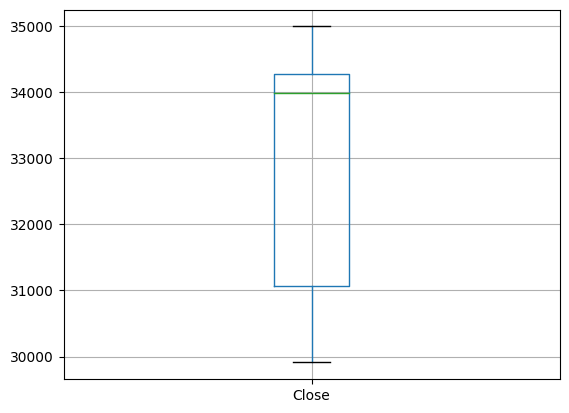

In [128]:
df_bitcoin_limpio.boxplot(['Close'])

In [129]:
Q1 = df_bitcoin_limpio['Close'].quantile(.25)
Q3 = df_bitcoin_limpio['Close'].quantile(.75)
rango = (df_bitcoin_limpio['Close'] >= Q1) & (df_bitcoin_limpio['Close'] <= Q3)
df_bitcoin_limpio = df_bitcoin_limpio[rango]

In [130]:
def limpieza_datos():
  global media_bitcoin, df_bitcoin_limpio, df_bitcoin
  df_bitcoin_limpio = df_bitcoin.copy()
  df_bitcoin_limpio = df_bitcoin_limpio[df_bitcoin_limpio['Volume'] > 0]
  df_bitcoin_limpio.dropna(subset = ['Close'], inplace = True)
  indices_unicos = df_bitcoin_limpio.index.drop_duplicates()
  df_bitcoin_limpio = df_bitcoin_limpio.reindex(indices_unicos)
  Q1 = df_bitcoin_limpio['Close'].quantile(.25)
  Q3 = df_bitcoin_limpio['Close'].quantile(.75)
  rango = (df_bitcoin_limpio['Close'] >= Q1) & (df_bitcoin_limpio['Close'] <= Q3)
  df_bitcoin_limpio = df_bitcoin_limpio[rango]
  media_bitcoin = df_bitcoin_limpio['Close'].mean()
limpieza_datos()

#4. Tomar decisiones

In [131]:
def tomar_decisiones():
  global algoritmo_decision, media_bitcoin, precio_actual
  if precio_actual >= media_bitcoin and tendencia == 'baja':
    algoritmo_decision = 'Vender'
  elif precio_actual < media_bitcoin and tendencia == 'alta':
    algoritmo_decision = 'Comprar'
  else:
    algoritmo_decision = 'Esperar'

#5. Visualización

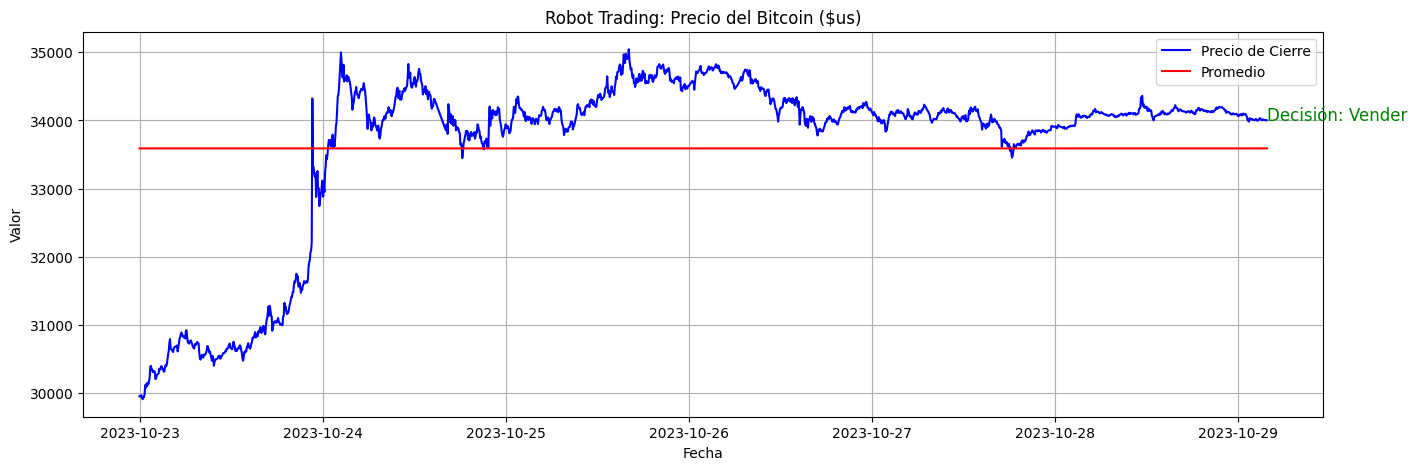

Precio Actual: 34010.15
Media Bitcoin: 33589.14601582228
Tendencia: alta
Algoritmo de Decisión: Vender


In [133]:
def visualizacion():
    global df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision

    # Agregar la columna "Promedio" al DataFrame original
    df_bitcoin['Promedio'] = media_bitcoin

    # Configurar el tamaño del gráfico
    plt.figure(figsize=(16, 5))

    # Agregar un título al gráfico
    plt.title("Robot Trading: Precio del Bitcoin ($us)")

    # Plotear una línea con los datos del índice y la columna "Close"
    plt.plot(df_bitcoin.index, df_bitcoin['Close'], label='Precio de Cierre', color='blue')

    # Plotear la línea promedio
    plt.plot(df_bitcoin.index, df_bitcoin['Promedio'], label='Promedio', color='red', linestyle='-')

    # Mostrar decisión
    plt.annotate(f'Decisión: {algoritmo_decision}', xy=(df_bitcoin.index[-1], df_bitcoin['Close'].iloc[-1]), fontsize=12, color='green')

    # Configurar etiquetas
    plt.xticks(rotation=360)

    # Agregar leyenda al gráfico
    plt.legend()

    # Mostrar el gráfico en pantalla
    plt.xlabel('Fecha')
    plt.ylabel('Valor')
    plt.grid(True)
    plt.show()

# Llamar la función
visualizacion()

# Imprimir variables
print("Precio Actual:", precio_actual)
print("Media Bitcoin:", media_bitcoin)
print("Tendencia:", tendencia)
print("Algoritmo de Decisión:", algoritmo_decision)

#6. Automatización

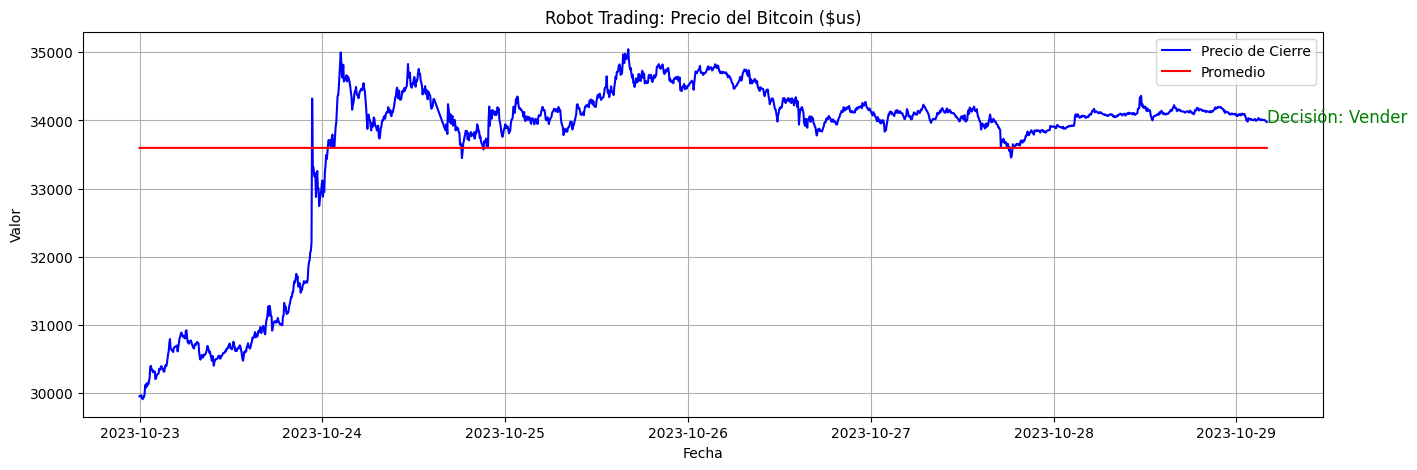

KeyboardInterrupt: ignored

In [137]:
while(True):
  clear_output()
  importar_base_bitcoin()
  extraer_tendencias()
  limpieza_datos()
  tomar_decisiones()
  visualizacion()
  time.sleep(300)